## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import numpy as np
import sys
sys.path.append('/content/drive/MyDrive/247-NeuralNetwork/247-hw2/utils')
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [102]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/content/drive/MyDrive/247-NeuralNetwork/247-hw2/cifar10' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [103]:
sys.path.append('/content/drive/MyDrive/247-NeuralNetwork/247-hw2/nndl')
from softmax import Softmax

In [104]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

In [105]:
softmax.W.shape

(10, 3073)

#### Softmax loss

In [106]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [107]:
print(loss)

2.3277607028048966


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

Because we use cross-entropy loss function, and here the 10 classes are generated identically and independently, where the loss: -log(0.1) = ln10, which is nearly 2.3

#### Softmax gradient

In [108]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.
loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -0.727595 analytic: -0.727595, relative error: 4.654671e-08
numerical: -0.404077 analytic: -0.404077, relative error: 6.201677e-08
numerical: 1.442401 analytic: 1.442401, relative error: 8.082628e-09
numerical: 2.389790 analytic: 2.389790, relative error: 1.572404e-08
numerical: -0.678154 analytic: -0.678154, relative error: 4.866813e-08
numerical: 0.749081 analytic: 0.749081, relative error: 2.592979e-08
numerical: -0.308555 analytic: -0.308555, relative error: 1.613334e-07
numerical: -0.205333 analytic: -0.205333, relative error: 1.324672e-07
numerical: 1.023490 analytic: 1.023490, relative error: 9.003331e-09
numerical: -2.016680 analytic: -2.016680, relative error: 2.853539e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [109]:
import time

In [110]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.3286275304462136 / 301.43147632796 computed in 0.08835244178771973s
Vectorized loss / grad: 2.3203553798082512 / 301.43147632796 computed in 0.022374868392944336s
difference in loss / grad: 0.008272150637962383 /2.1280622835041762e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 2.328220195265812
iteration 100 / 1500: loss 1.9892977564285708
iteration 200 / 1500: loss 1.9472858098340935
iteration 300 / 1500: loss 1.877450309136766
iteration 400 / 1500: loss 1.842071218236199
iteration 500 / 1500: loss 1.7110450225057678
iteration 600 / 1500: loss 1.6892895379499018
iteration 700 / 1500: loss 1.6915960237252525
iteration 800 / 1500: loss 1.6638178461737496
iteration 900 / 1500: loss 1.7487862959248344
iteration 1000 / 1500: loss 1.836387698967032
iteration 1100 / 1500: loss 1.6906491479127783
iteration 1200 / 1500: loss 1.654612631926646
iteration 1300 / 1500: loss 1.5900062992072361
iteration 1400 / 1500: loss 1.678821742271397
That took 9.339524030685425s


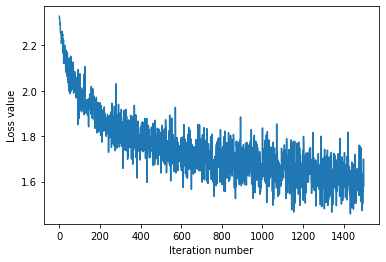

In [111]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [112]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3811428571428571
validation accuracy: 0.398


## Optimize the softmax classifier

In [113]:
np.finfo(float).eps

2.220446049250313e-16

In [114]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
import warnings
warnings.filterwarnings('ignore')
learning_rate = [1e-8,1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2,1e-1]
val_acc = []
best_lr = learning_rate[0]
best_acc = 0
for i in range(len(learning_rate)):
  lr = learning_rate[i]
  softmax.train(X_train,y_train,learning_rate = lr, num_iters = 1500)
  y_pred = softmax.predict(X_val)
  acc = np.mean(np.equal(y_pred,y_val))
  val_acc.append(acc)
  print('learning rate:', lr, '  val accuracy:', acc)
  if acc > best_acc:
    best_acc = acc
    best_lr = lr
print('-----------------------------------')
print('best lr for my softmax: ', best_lr)
print('best validation accuracy: ', best_acc)
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


learning rate: 1e-08   val accuracy: 0.308
learning rate: 1e-07   val accuracy: 0.381
learning rate: 1e-06   val accuracy: 0.405
learning rate: 1e-05   val accuracy: 0.291
learning rate: 0.0001   val accuracy: 0.314
learning rate: 0.001   val accuracy: 0.232
learning rate: 0.01   val accuracy: 0.257
learning rate: 0.1   val accuracy: 0.282
-----------------------------------
best lr for my softmax:  1e-06
best validation accuracy:  0.405
